# 2.3.6 ガウス分布に対するベイズ推論

この節の冒頭の問題  
『１変数のガウス確率変数 $x$ の簡単な例から始めよう。分散 $\sigma^2$ は基地とし、与えられた $N$ 個の観測値集合 ${\bf x}\ =\ \left\{x_1, \dots, x_N\right\}$ から、平均 $\mu$ を推定する問題を考える。』  
  
尤度関数 $p({\bf x}|\mu) $ は
$$
p({\bf x}|\mu)\ =\ \prod_{n=1}^{N}p(x_n|\mu)\ =\ \frac{1}{(2\pi\sigma^2)^{N/2}}\exp\left[-\frac{1}{2\sigma^2}\sum_{n=1}^{N} (x_n-\mu)^2\right]
$$
で、指数部分が $\mu$ についての２次式となっているため、これに対する共役事前分布はガウス分布である。
$$
p(\mu)\ =\ {\cal N}(\mu|\mu_0, \sigma_0^2)
$$
事後分布は
$$
p(\mu|{\bf x})\ \propto\ p({\bf x}|\mu)p(\mu)
$$

In [1]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.stats import norm
from operator import mul
from math import sqrt

In [2]:
VAR = 0.1

## 逐次推定　手法1
ベイズの定理に従って事後分布を計算する：
$$
\begin{align}
p(\mu\ | x_{n},\ \cdots,\ x_{1}) = \frac{p(x_{n}\ | \mu) p(\mu\ | x_{n-1},\ \cdots,\ x_{1})}{p(x_{n})}
\end{align}
$$
事後分布を $\mu$ の関数としたものを返す高階関数 `posteriorDist(x, priorDist)`を定義する  
* 尤度関数 $p(x_i\ |\ \mu)$ は、`likelihood(x, m)`  
* 事前分布 $p(\theta\ |x_{n-1},\ \cdots,\ x_{1})$ は $\mu$ の関数として、引数 `priorDist`で与える
* 分母の $p(x_{n})$ は $\theta$ には依らないので、規格化定数と考えて良い。分子の $\mu$ についての積分
$$
\begin{align}
p(x_{n}) = \int_{-\infty}^{\infty} p(x_{n}\ |\ \mu) p(\mu\ |\ x_{n-1},\ \cdots,\ x_{1}) d\mu
\end{align}
$$
で与えられる

In [3]:
def likelihood(x, m):
    return norm.pdf(x, loc=m, scale=sqrt(VAR))

In [4]:
def priorDist(m):
    return norm.pdf(m, loc=0, scale=sqrt(VAR))

In [5]:
def posteriorDist(x, priorDist):
    # 与えられた x に対する分子の計算
    def _numerator(t):
        return likelihood(x, t) * priorDist(t)

    # 分母を求めるために分子を積分
    denominator = quad(_numerator, -np.inf, +np.inf)[0]

    # 返り値となる事後確率分布
    def _postDist(t):
        return _numerator(t) / denominator

    # np.vectorize で np.ndarray を引数に取れる関数にする
    return _postDist

In [6]:
def getSequentialDist1(xVec, priorDist):
    # 事後分布を入れるリスト 事前分布 priorDist も入れる
    distList = [priorDist]
    # データ xVec を一つずつ使って事後分布を計算していく
    for x in xVec:
        # posteriorDist() でできた事後分布をリストに append して、
        # 次のループでリストの末尾 distList[-1] として利用する
        distList.append(posteriorDist(x, distList[-1]))
    return distList

In [7]:
def ex1(xVec):
    print xVec
    # 更新されていく事後分布のリスト
    distList = getSequentialDist1(xVec, priorDist)
    #distList = getSequentialDist(xVec, priorDist1)
    cols = plt.cm.rainbow(np.linspace(0, 1, len(xVec) + 1))
    for i, (dist, c) in enumerate(zip(distList, cols)):
        mu = np.linspace(-1, 1.5, 200)
        plt.plot(mu, [dist(m) for m in mu], c=c, label='No.{:2d}'.format(i))
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid()
    plt.show()

[ 1.07298813  1.10343181  0.98568395  0.72121076  0.39440461  1.40357308
  0.49098533  0.91853833  0.48615045  1.14930703]


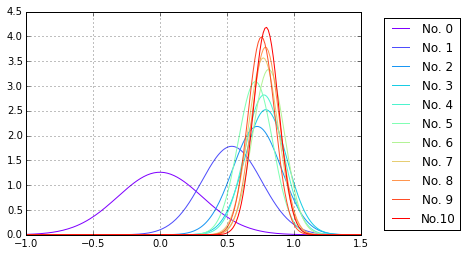

In [8]:
# データ
xVec = norm.rvs(loc=0.8, scale=sqrt(VAR), size=10)
ex1(xVec)

---
## 逐次推定 手法2
手法1では正規化のための積分に時間がかかってしまう。  
事後分布を得るために積分して正規化するのではなく、2つのガウス分布の積の指数部分を平方完成することで、事後分布の平均(2.141)と分散(2.142)を計算した
$$
\begin{align}
\mu_N &= \frac{\sigma^2}{N\sigma_0^2+\sigma^2}\mu_0 + \frac{N\sigma_0^2}{N\sigma_0^2+\sigma^2}\mu_{\rm ML} \\
\frac{1}{\sigma_N^2} &= \frac{1}{\sigma_0^2} + \frac{N}{\sigma^2}
\end{align}
$$
これを元に演習2.39では $\mu_N$ と $\sigma_N^2$ の逐次更新の式を得た。
$$
\begin{align}
\mu_N &= \frac{\sigma_N^2}{\sigma_{N-1}^2}\mu_{N-1} + \frac{\sigma_N^2}{\sigma^2}x_N \left(= \frac{\sigma^2}{\sigma^2+\sigma_{N-1}^2}\mu_{N-1} + \frac{\sigma_N^2}{\sigma^2}x_N \right) \\
\frac{1}{\sigma_N^2} &= \frac{1}{\sigma_{N-1}^2} + \frac{1}{\sigma^2}
\end{align}
$$
それを使って逐次推定する。

In [9]:
def calPosteriorDistParm(x, priorMu, priorVar):
    """
    mu_Nとvar_Nの逐次更新の実装
    """
    nextVar = 1 / (1/priorVar + 1/VAR)
    nextMu = nextVar/priorVar * priorMu + nextVar/VAR * x
    return nextMu, nextVar

In [10]:
def getSequentialDist2(xVec, priorMu, priorVar):
    """
    共役事前分布のガウス分布のパラメータpriorMu, priorVarと観測データxVecから
    逐次更新で得られたmuの事後分布のリストを返す
    """
    # RV objectのリスト
    rvObjectList = [norm(loc=priorMu, scale=sqrt(priorVar))]
    for x in xVec:
        # 一個前のRV object
        priorRV = rvObjectList[-1]
        # その平均と分散 \mu_{N-1} と \sigma_{N-1} に当たる　
        pMu, pVar = priorRV.mean(), priorRV.var()
        # 事後分布のパラメータ
        mu, var = calPosteriorDistParm(x, pMu, pVar)
        # それを元にRV objectを作ってリストに格納
        rvObjectList.append(norm(loc=mu, scale=sqrt(var)))
    # RV object => その分布を表すpdfメソッドにしてリストに詰める
    distList = [rv.pdf for rv in rvObjectList]
    return distList                                       

In [11]:
def ex2(xVec):
    print xVec
    # 事前分布のパラメータ
    priorMu, priorVar = 0, VAR
    # 更新されていく事後分布のリスト
    distList = getSequentialDist2(xVec, priorMu, priorVar)
    #distList = getSequentialDist(xVec, priorDist1)
    cols = plt.cm.rainbow(np.linspace(0, 1, len(xVec) + 1))
    for i, (dist, c) in enumerate(zip(distList, cols)):
        mu = np.linspace(-1, 1.5, 200)
        plt.plot(mu, [dist(m) for m in mu], c=c, label='No.{:2d}'.format(i))
    plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
    plt.grid()
    plt.show()

[ 1.13522887  0.55678245  1.18826053  0.45949592  0.48651778  0.58032488
  0.19199509  1.02799224  0.96693311  0.35176282  1.06586908  0.62717726
  0.48314054  0.20234592  1.36326128  1.02876801  1.21102105  0.87116533
  0.88703663  0.55074699]


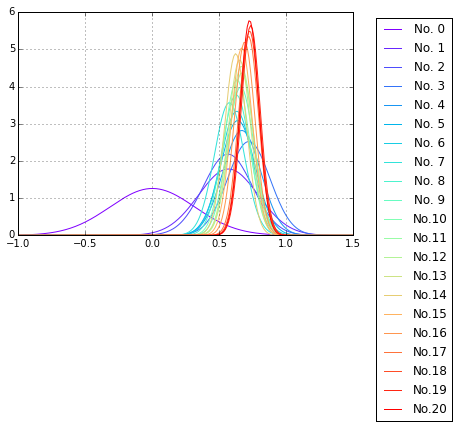

In [12]:
# データ
xVec = norm.rvs(loc=0.8, scale=sqrt(VAR), size=20)
ex2(xVec)

---

[ 0.55402738  0.62630949  0.96591438  1.04264679  0.76465508  0.43215298
  0.77094904  0.59513676  1.07952893  1.15701354]


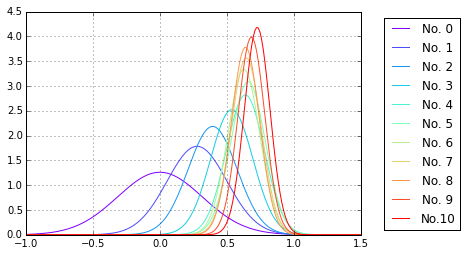

[ 0.55402738  0.62630949  0.96591438  1.04264679  0.76465508  0.43215298
  0.77094904  0.59513676  1.07952893  1.15701354]


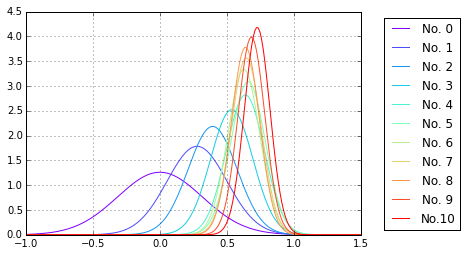

In [13]:
# ２つの手法が同じ結果を出すか比較する
xVec = norm.rvs(loc=0.8, scale=sqrt(VAR), size=10)
ex1(xVec)
ex2(xVec)